In [1]:
# 50.データの入手・整形
import pandas as pd
from sklearn.model_selection import train_test_split

# (1.)
# !unzip NewsAggregatorDataset.zip -d NewsAggregatorDataset

# (2.)
df = pd.read_csv('NewsAggregatorDataset/newsCorpora.csv', header=None, sep='\t',
                 names=['id', 'title', 'url', 'publisher', 'category', 'story', 'hostname', 'timestamp'])
cols = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
df = df[df['publisher'].isin(cols)]

# (3.)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# (4.)
# train 0.8, valid 0.1, test 0.1
train, valid_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['category'])
valid, test = train_test_split(valid_test, test_size=0.5, random_state=42, stratify=valid_test['category'])

# データの保存
train = train[['title','category']].reset_index(drop=True)
valid = valid[['title','category']].reset_index(drop=True)
train_valid = pd.concat([train, valid], axis=0)
test = test[['title','category']].reset_index(drop=True)


train.to_csv('train.txt', sep='\t', index=False)
valid.to_csv('valid.txt', sep='\t', index=False)
test.to_csv('test.txt', sep='\t', index=False)

print('train ---- ', train.shape)
print(train['category'].value_counts())
print('valid ---- ', valid.shape)
print(valid['category'].value_counts())
print('test ----', test.shape)
print(test['category'].value_counts())

train ----  (10672, 2)
b    4502
e    4223
t    1219
m     728
Name: category, dtype: int64
valid ----  (1334, 2)
b    562
e    528
t    153
m     91
Name: category, dtype: int64
test ---- (1334, 2)
b    563
e    528
t    152
m     91
Name: category, dtype: int64


In [3]:
# 51. 特徴量抽出
"""
51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． 
なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．
"""
import re
import string
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# 前処理
def preprocess(text):
    # Remove diacritics
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")

    # Lowercase the string
    text = text.lower()

    # Remove punctuation
    text = ''.join(c for c in text if c not in string.punctuation)

    # Remove numbers
    text = re.sub('\d', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    clean_text = [w for w in word_tokens if not w in stop_words]

    return ' '.join(clean_text)

train_valid['clean_title'] = train_valid['title'].apply(preprocess)
test['clean_title'] = test['title'].apply(preprocess)



Note：
https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

https://datascience.stackexchange.com/questions/12321/whats-the-difference-between-fit-and-fit-transform-in-scikit-learn-models/12346#12346

In [33]:
# 特徴量抽出
# TfidfVectorizer
# Ignore terms that have a document frequency lower than 5 and higher than 5% 
vec_tfidf = TfidfVectorizer(min_df=5, max_df=0.05, ngram_range=(1, 2))

# ベクトル化
X_train_valid = vec_tfidf.fit_transform(train_valid['clean_title'])  # testの情報は使わない
X_test = vec_tfidf.transform(test['clean_title'])

# ベクトルをデータフレームに変換
X_train_valid = pd.DataFrame(X_train_valid.toarray(), columns=vec_tfidf.get_feature_names_out())
X_test = pd.DataFrame(X_test.toarray(), columns=vec_tfidf.get_feature_names_out())

# 分割して保存
X_train = X_train_valid[:len(train)].reset_index(drop=True)
X_valid = X_train_valid[len(train):].reset_index(drop=True)

X_train.to_csv('X_train.txt', sep='\t', index=False)
X_valid.to_csv('X_valid.txt', sep='\t', index=False)
X_test.to_csv('X_test.txt', sep='\t', index=False)

print('X_train ---- ', X_train.shape)
print('X_valid ---- ', X_valid.shape)
print('X_test ---- ', X_test.shape)

X_train ----  (10672, 4960)
X_valid ----  (1334, 4960)
X_test ----  (1334, 4960)


In [34]:
X_train.head()

,aa,aa outlook,aaa,aaliyah,aaliyah lifetime,abbvie,abc,abortion,abrams,abramson,...,zebra,zendaya,zeppelin,zero,zone,zone bond,zone bonds,zone inflation,zs,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# 52. 学習
from sklearn.linear_model import LogisticRegression

# モデルの学習
lg = LogisticRegression(random_state=123, solver='lbfgs', max_iter=10000)
lg.fit(X_train, train['category'])

LogisticRegression(max_iter=10000, random_state=123)

In [36]:
# 53. 予測
import numpy as np

def score_lg(lg, X):
  return [lg.predict(X), np.max(lg.predict_proba(X), axis=1)]

valid_pred = score_lg(lg, X_valid)
train_pred = score_lg(lg, X_train)
test_pred = score_lg(lg, X_test)

print(train_pred)

[array(['e', 'b', 't', ..., 'e', 'b', 'b'], dtype=object), array([0.84295916, 0.97893811, 0.54671478, ..., 0.94595864, 0.83843938,
       0.75087409])]


In [37]:
# 54. 正解率の計測
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train['category'], train_pred[0])
valid_accuracy = accuracy_score(valid['category'], valid_pred[0])
test_accuracy = accuracy_score(test['category'], test_pred[0])
print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（検証データ）：{valid_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')

正解率（学習データ）：0.943
正解率（検証データ）：0.880
正解率（評価データ）：0.885


[[4419   43    3   37]
 [  26 4190    1    6]
 [  90  109  523    6]
 [ 186   95    6  932]]


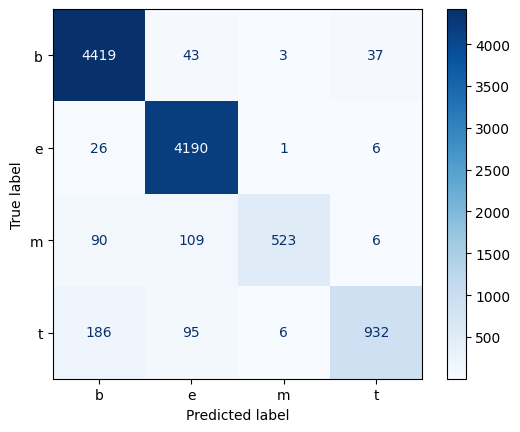

In [38]:
# 55. 混同行列の作成
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import seaborn as sns
import matplotlib.pyplot as plt

# 学習データ
train_cm = confusion_matrix(train['category'], train_pred[0], labels = lg.classes_ )
print(train_cm)
train_disp = ConfusionMatrixDisplay(confusion_matrix= train_cm, display_labels= lg.classes_)
train_disp.plot(cmap=plt.cm.Blues)

[[532  20   2   9]
 [ 13 514   0   1]
 [ 17  21  53   0]
 [ 42  28   1  81]]


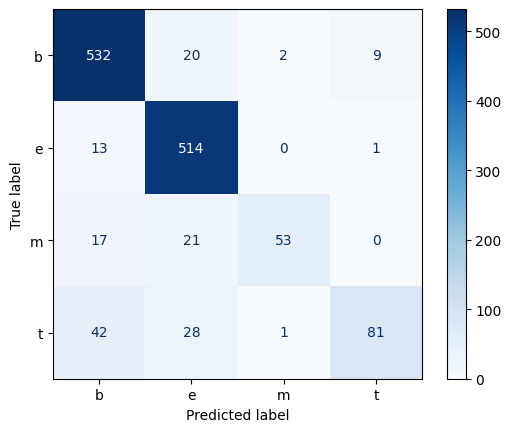

In [40]:
# 評価データ
test_cm = confusion_matrix(test['category'], test_pred[0], labels = lg.classes_ )
print(test_cm)
test_disp = ConfusionMatrixDisplay(confusion_matrix= test_cm, display_labels= lg.classes_)
test_disp.plot(cmap=plt.cm.Blues)

In [41]:
# 56 適合率，再現率，F1スコアの計測
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_scores(y_true, y_pred):
  # 適合率
  precision = precision_score(test['category'], test_pred[0], average=None, labels = lg.classes_)  # Noneを指定するとクラスごとの精度をndarrayで返す
  precision = np.append(precision, precision_score(y_true, y_pred, average='micro'))  # 末尾にマイクロ平均を追加
  precision = np.append(precision, precision_score(y_true, y_pred, average='macro'))  # 末尾にマクロ平均を追加

  # 再現率
  recall = recall_score(test['category'], test_pred[0], average=None, labels=lg.classes_)
  recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
  recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))

  # F1スコア
  f1 = f1_score(test['category'], test_pred[0], average=None, labels=lg.classes_)
  f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
  f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))

  # 結果を結合してデータフレーム化
  scores = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},
                        index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])

  return scores

print(calculate_scores(test['category'], test_pred[0]))

             適合率       再現率     F1スコア
b       0.880795  0.944938  0.911740
e       0.881647  0.973485  0.925293
t       0.946429  0.582418  0.721088
m       0.890110  0.532895  0.666667
マイクロ平均  0.884558  0.884558  0.884558
マクロ平均   0.899745  0.758434  0.806197


In [42]:
# 57 特徴量の重みの確認
features = X_train.columns.values
index = [i for i in range(1, 11)]
for c, coef in zip(lg.classes_, lg.coef_):
  print(f'【カテゴリ】{c}')
  best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=index).T
  worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重要度下位'], index=index).T
  display(pd.concat([best10, worst10], axis=0))
  print('\n')

【カテゴリ】b


,1,2,3,4,5,6,7,8,9,10
重要度上位,bank,fed,ecb,stocks,china,profit,euro,ukraine,growth,ipo
重要度下位,ebola,video,microsoft,facebook,heart,virus,star,aereo,tv,google




【カテゴリ】e


,1,2,3,4,5,6,7,8,9,10
重要度上位,chris,kardashian,movie,film,beyonce,kim,wedding,star,paul,miley
重要度下位,google,study,gm,china,says,sales,data,billion,ceo,rise




【カテゴリ】m


,1,2,3,4,5,6,7,8,9,10
重要度上位,ebola,cancer,study,drug,fda,mers,health,medical,doctors,heart
重要度下位,gm,deal,facebook,sales,twitter,apple,climate,bank,fed,ceo




【カテゴリ】t


,1,2,3,4,5,6,7,8,9,10
重要度上位,google,facebook,microsoft,apple,climate,gm,nasa,tesla,moon,googles
重要度下位,drug,stocks,american,shares,fed,cancer,ecb,obamacare,ebola,percent


In [66]:
# 58. 正則化パラメータの変更 
from tqdm import tqdm

result = []
for C in tqdm(np.logspace(-5, 4, 10, base=10)):
  # モデルの学習
  # Smaller values of C specify stronger regularization
  lg = LogisticRegression(random_state=123, max_iter=10000, C=C)
  lg.fit(X_train, train['category'])

  # 予測値の取得
  train_pred = score_lg(lg, X_train)
  valid_pred = score_lg(lg, X_valid)
  test_pred = score_lg(lg, X_test)

  # 正解率の算出
  train_accuracy = accuracy_score(train['category'], train_pred[1])
  valid_accuracy = accuracy_score(valid['category'], valid_pred[1])
  test_accuracy = accuracy_score(test['category'], test_pred[1])

  # 結果の格納
  result.append([C, train_accuracy, valid_accuracy, test_accuracy])

100%|██████████| 10/10 [02:43<00:00, 16.31s/it]


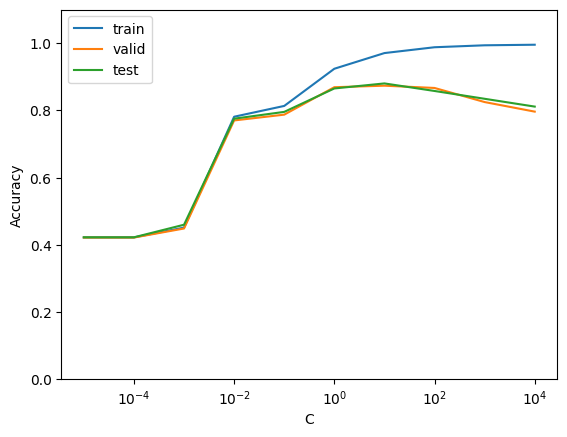

In [67]:
# 視覚化
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

In [48]:
# 59. ハイパーパラメータの探索
# pip install optuna
import optuna

# 最適化対象を関数で指定
def objective_lg(trial):
  # チューニング対象パラメータのセット
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
  C = trial.suggest_loguniform('C', 1e-4, 1e4)

  # モデルの学習
  # 'elasticnet' is a type of regularization that combines L1 and L2 penalties.
  # The l1_ratio parameter controls the balance between L1 and L2 regularization. A value of 0 corresponds to L2 penalty only (Ridge regression) and a value of 1 to L1 penalty only (Lasso regression).
  lg = LogisticRegression(random_state=123, 
                          max_iter=10000, 
                          penalty='elasticnet', 
                          solver='saga', 
                          l1_ratio=l1_ratio, 
                          C=C)
  lg.fit(X_train, train['category'])

  # 予測値の取得
  valid_pred = score_lg(lg, X_valid)

  # 正解率の算出
  valid_accuracy = accuracy_score(valid['category'], valid_pred[0])    

  return valid_accuracy 

In [49]:
# 最適化
study = optuna.create_study(direction='maximize')
study.optimize(objective_lg, timeout=3600)

# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

[I 2023-06-19 15:01:11,595] A new study created in memory with name: no-name-ef1ff0de-778f-4175-bb69-40915dbb4570
/var/folders/_t/r2bcv22124721pbl9zz3h0nh0000gn/T/ipykernel_7882/4128615889.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
/var/folders/_t/r2bcv22124721pbl9zz3h0nh0000gn/T/ipykernel_7882/4128615889.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e4)
[I 2023-06-19 15:01:42,323] Trial 0 finished with value: 0.4490254872563718 and parameters: {'l1_ratio': 0.6846290600704323, 'C': 0.027586882185669244}. Best is trial 0 with value: 0.4490254872563718.
/var/folders/_t/r2bcv22124721

Best trial:
  Value: 0.890
  Params: 
    l1_ratio: 0.8518481112003959
    C: 41.738988797732226
